<h1>Siamese Network with Manhattan LSTM<h1>
<h5>Here we use Siamese network as a fewshot mehanism to classify tweets<h5>

In [3]:
#importing libraries
from sklearn.metrics import confusion_matrix
from sklearn import model_selection
import pandas as pd
import numpy as np 
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, Subtract, LSTM, Embedding, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.initializers import Constant
from tensorflow.keras.models import Sequential, Model
import itertools
from keras.optimizers import Adam
from keras.optimizers import SGD
import dill
import gensim
import matplotlib.pyplot as plt
from sklearn import metrics

2023-08-15 16:05:04.797338: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h5>All experiements in this notebook is performed with raw tweets as input data<h5>

In [3]:
train_df = pd.read_pickle('./train_df.pkl')
test_df = pd.read_pickle('./test_df.pkl')

In [1]:
#The below code is used to create a few shot corpus by selecting 50 examples each from both class. Once generated its saved as a pickle file
'''positive_examples = train_df[train_df['related_manual']==1].head(50)
negative_examples = train_df[train_df['related_manual']==0].head(50)
fewshot_df = pd.concat([positive_examples,negative_examples])
fewshot_df.to_pickle('./fewshot_df_100.pkl')'''

"positive_examples = train_df[train_df['related_manual']==1].head(50)\nnegative_examples = train_df[train_df['related_manual']==0].head(50)\nfewshot_df = pd.concat([positive_examples,negative_examples])\nfewshot_df.to_pickle('./fewshot_df_100.pkl')"

In [5]:
fewshot_df = pd.read_pickle('./fewshot_df_100.pkl')

In [6]:
#helper function to generate pairwise dataset
def get_pairwise_dataset(df,train_column_name,target_column_name):
    
    frame_train = {'Tweet': df[train_column_name],
         'Class': df[target_column_name]}
    df_train = pd.DataFrame(frame_train)
    
    labels = df_train['Class'].unique()
    
     #initialise empty arrays for storing left and right tweets
    lhs = []
    rhs = []
    is_similar = []
    
    for label in labels:
        print(label)
        similar_tweets = list(df_train[df_train['Class']==label]['Tweet'])
        similar_tweet_pairs = []
        #find combinations of 2 from similar tweets
        for i in range(len(similar_tweets)):
            for j in range(i+1,len(similar_tweets)):
                similar_tweet_pairs.append((similar_tweets[i], similar_tweets[j]))
                
        
        print(len(similar_tweet_pairs))
        for pair in similar_tweet_pairs:
            lhs.append(pair[0])
            rhs.append(pair[1])
            
            #is_similar 1 since tweets belong to same class
            is_similar.append(1.0)
        
        #make random combinations for different tweets
        diffierent_tweets = df_train[df_train['Class']!=label]['Tweet']
        for i in range(len(similar_tweet_pairs)):
            lhs.append(np.random.choice(similar_tweets))
            rhs.append(np.random.choice(diffierent_tweets))
            
            #is_smilar 0 becuase tweets belong to different class
            is_similar.append(0.0)
            
    dataset = pd.DataFrame({'left_tweet':lhs,
    'right_tweet':rhs,
    'is_similar': is_similar})
    
    return dataset

In [7]:
#setting a fixed upper limit for the unique number of words
len_vocab = 10000

In [8]:
#helper function to tokenize the tweets
def get_tokenized_data(dataset, data_column_name, target_column_name):
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(train_df[data_column_name])
    left_tweet_tokenized = tokenizer.texts_to_sequences(dataset.left_tweet)
    right_tweet_tokenized = tokenizer.texts_to_sequences(dataset.right_tweet)
    tweet_tokenized = tokenizer.texts_to_sequences(train_df[data_column_name])
    text_complete = tokenizer.sequences_to_texts(tweet_tokenized)
    text_complete = [item.split() for item in text_complete]
    
    #word index is the lookup dictionary with unique words and their corresponding token ids
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    #padding sequences for uniform representation for learning
    left_tweet_padded = pad_sequences(left_tweet_tokenized, 300)
    right_tweet_padded = pad_sequences(right_tweet_tokenized, 300)

    print(left_tweet_padded.shape)
    print(right_tweet_padded.shape)
    return left_tweet_padded,right_tweet_padded,text_complete, word_index, tokenizer

In [9]:
#generate pairwise dataset from the 100 examples
dataset_pairwise = get_pairwise_dataset(fewshot_df, 'tweet_original','related_manual')
dataset_pairwise

1.0
1225
0.0
1225


,left_tweet,right_tweet,is_similar
0,The third point from Dave focuses on the oppor...,@Rythmol81 @tan123 Water vapour is a far more ...,1.0
1,The third point from Dave focuses on the oppor...,There is no such thing as “clean coal”. This i...,1.0
2,The third point from Dave focuses on the oppor...,Come and join us: CARBON CAPTURE AND STORAGE; ...,1.0
3,The third point from Dave focuses on the oppor...,Did you know that Eel grass is fantastic carbo...,1.0
4,The third point from Dave focuses on the oppor...,"Why does carbon capture &amp; storage matter, ...",1.0
...,...,...,...
4895,@alasdairrr @joncstone You’re preaching to the...,Solely reared outdoors on rough pasture the fa...,0.0
4896,@alasdairrr @joncstone You’re preaching to the...,@lizlaineuk @RobertJenrick Hello Liz. You make...,0.0
4897,@TheMockneyRebel @Tim_Aker \n\nVote UKIP Scott...,@McCarthyMyles @James_BG @C_CaptureCO2 2/2\r\n...,0.0
4898,@LallyLangford He was a total waste of money w...,It’s what we’ve been giving a lot of thought t...,0.0


In [12]:
tweet_left, tweet_right, tokenized_tweets, word_index, tokenizer = get_tokenized_data(dataset_pairwise,'tweet_original','related_manual')

Found 12593 unique tokens.
(4900, 300)
(4900, 300)


In [14]:
%%time
#generate word2vec embeddings
word2vector_model = gensim.models.Word2Vec(
            tokenized_tweets,
            size=300,
            window=5,
            min_count=2,                                  
            sg = 1,
            hs = 0,
            negative = 10,
            workers= 10
) 

word2vector_model.train(tokenized_tweets, total_examples= len(tokenized_tweets), epochs=20)

CPU times: user 15.3 s, sys: 88.7 ms, total: 15.3 s
Wall time: 3.59 s


(775334, 1144040)

In [15]:
num_words = min(len_vocab, len(word_index)) + 1

In [16]:
#helper function to generate embedding matrix for word2vec embeddings of each unique word in the word index
def get_word2vec_embedding(word_index):
    embedding_matrix = np.zeros((num_words, 300))
    for word, i in word_index.items():
        if i > len_vocab:
            continue
        try:
            embedding_vector = word2vector_model[word].reshape((1, 300))
        except KeyError:
            continue
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [17]:
#generate the word2vec embedding matrix
word2vec_embedding_matrix = get_word2vec_embedding(word_index)
word2vec_embedding_matrix

/var/folders/yp/w3wbm1755g3dkb_6mbfzm41r0000gn/T/ipykernel_1202/2162501271.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_vector = word2vector_model[word].reshape((1, 300))


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.11962535,  0.04370611, -0.00162561, ..., -0.0747209 ,
         0.13890952,  0.05274491],
       [-0.11766548,  0.05881355,  0.02946457, ...,  0.09679773,
        -0.02271657,  0.00747269],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [22]:
#define manhattan distance function
def manhattan(difference):
    return K.exp(-K.sum(K.abs(difference), axis=1, keepdims=True))

In [100]:
#helper to initalise the siamese network
def initialise_siamese_network(size, embedding_matrix, optimiser='adam', lr=0.01):
    
    if optimiser == 'adam':
        optimizer = Adam
    elif optimiser == 'sgd':
        optimizer = SGD

    
    left_input_layer = Input((size,))
    right_input_layer = Input((size,))

    
    embedding_layer = Embedding(num_words,
                                300,
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=size,
                                trainable=False)

    sequential_layer = Sequential()
    sequential_layer.add(embedding_layer)
    sequential_layer.add(LSTM(50, dropout=0.3, recurrent_dropout=0.))

    left_output_layer = sequential_layer(left_input_layer)
    right_output_layer = sequential_layer(right_input_layer)

    
    difference_layer = Subtract()([left_output_layer, right_output_layer])
    malstm_difference = Lambda(manhattan)(difference_layer)

    siamese_network = Model(inputs=[left_input_layer, right_input_layer], outputs=malstm_difference)
    siamese_network.compile(loss="binary_crossentropy", optimizer=optimizer(learning_rate=lr,clipnorm=1.0), metrics=['accuracy'])

    return siamese_network

In [24]:
#helper for prediction
def predict(tweet, train_data, compare_sequence, model):
    #convert tweet into tokenized sequence
    sequence = tokenizer.texts_to_sequences(tweet.split())
    
    #convert the sequence into a flat 1-d array
    sequence = list(itertools.chain.from_iterable(sequence))
    
    #pad the sequence for uniform represntation 
    sequence = pad_sequences([sequence], maxlen=300)
    
    #replicate the sequence to match the number of comparision sequence, to calculate similarity of each comparison sequnce to the text sequence
    sequence_array = np.repeat(sequence, len(compare_sequence), axis=0)
    
    #predict similarity score
    scores = model.predict([sequence_array, compare_sequence])
    
    #find the most similar tweet's index
    top_index = np.argmax(scores)
    
    #return prediction
    prediction = train_data['related_manual'].iloc[top_index]
    return prediction

In [37]:
#helper for generating performance report
def performance(y_true,y_predict):
    TP = confusion_matrix(y_true,y_predict)[0,0]
    FP = confusion_matrix(y_true,y_predict)[0,1]
    TN = confusion_matrix(y_true,y_predict)[1,1]
    FN = confusion_matrix(y_true,y_predict)[1,0]
    TN, FP, FN, TP = confusion_matrix(y_true,y_predict).ravel()
    print(f"Accuracy: {round(((TP+TN)/(TP+TN+FP+FN))*100,3)}%")
    precision = round((TP/(TP+ FP))*100,3)
    recall = round((TP/(TP+ FN))*100,3)
    print(confusion_matrix(y_true,y_predict,labels=[1,0]).ravel())
    print(f"TP: {TP}")
    print(f"FP: {FP}")
    print(f"TN: {TN}")
    print(f"FN: {FN}")
    print(f"Sensitivity: {round((TP/(TP+ FN))*100,3)}%")
    print(f"Specificity: {round((TN/(TN + FP))*100,3)}%")
    print(f"Precision: {precision}%")
    print(f"Recall: {recall}%")
    print(f"f1: {round(((2*precision*recall)/(precision+recall)),3)}%")
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix(y_true,y_predict,labels=[1,0]), display_labels=[1,0])
    cm_display.plot()
    plt.show()
    
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_true,y_predict)
    area = metrics.auc(false_positive_rate, true_positive_rate)
    plt.figure()
    plt.plot(false_positive_rate, true_positive_rate, color='green', lw=2, label=f'ROC curve (Area Under Curve = {area:.2f})')
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [39]:
#helper to plot model accuracy curve
def plot_accuracy_curve (model):
    plt.plot(model.history['loss'])
    #plt.plot(model.history['val_accuracy'])
    plt.title('loss curve')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [25]:
#the compare tweet sequence hold the data from the fewshot corpus in the tokenized form.
#It is used to compare the similarity of a given tweet to each tweet in the few shot dataset.
compare_tweet_sequences = tokenizer.texts_to_sequences(fewshot_df.tweet_original)
compare_tweet_sequences_padded = pad_sequences(compare_tweet_sequences, maxlen=300)

<h2>Training and testing with different hyperparam combo<h2>

In [29]:
siamese_1 = initialise_siamese_network(300,word2vec_embedding_matrix,'adam',0.01)
siamese_1.summary()

2023-08-04 01:25:59.609630: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-04 01:25:59.609680: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-08-04 01:26:01.210335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 01:26:01.212040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 sequential (Sequential)        (None, 50)           3070500     ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 subtract (Subtract)            (None, 50)           0           ['sequential[0][0]',         

2023-08-04 01:26:01.607806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 01:26:01.608877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 01:26:01.610258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [31]:
%%time
model1 = siamese_1.fit([tweet_left, tweet_right], dataset_pairwise.is_similar, epochs=5)

Epoch 1/5


2023-08-04 01:27:47.298842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 01:27:47.300250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 01:27:47.301680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

154/154 [==============================] - 26s 138ms/step - loss: 0.4484 - accuracy: 0.8049
Epoch 2/5
154/154 [==============================] - 20s 132ms/step - loss: 0.1597 - accuracy: 0.9586
Epoch 3/5
154/154 [==============================] - 21s 135ms/step - loss: 0.0872 - accuracy: 0.9865
Epoch 4/5
154/154 [==============================] - 20s 132ms/step - loss: 0.0895 - accuracy: 0.9837
Epoch 5/5
154/154 [==============================] - 20s 131ms/step - loss: 0.0760 - accuracy: 0.9873
CPU times: user 1min 26s, sys: 20.3 s, total: 1min 46s
Wall time: 1min 48s


In [35]:
%%time
y_pred1 = [predict(tweet, fewshot_df, compare_tweet_sequences_padded,siamese_1) for tweet in test_df['tweet_original']]

2023-08-04 01:31:48.329640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 01:31:48.331366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 01:31:48.332380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 42ms/step
CPU times: user 1min 34s, sys: 17.3 s, total: 1min 51s
Wall time: 2min 3s


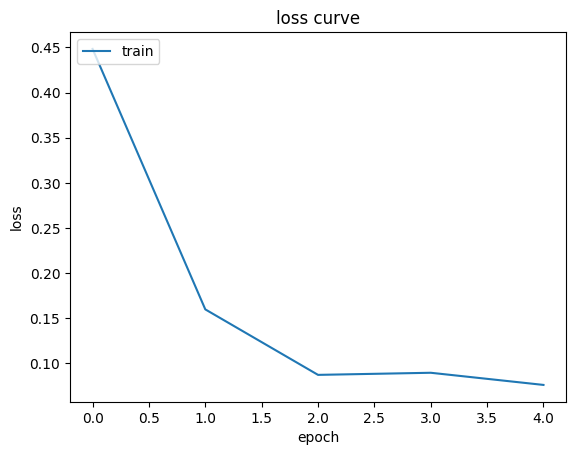

Accuracy: 90.2%
[233  17  32 218]
TP: 233
FP: 32
TN: 218
FN: 17
Sensitivity: 93.2%
Specificity: 87.2%
Precision: 87.925%
Recall: 93.2%
f1: 90.486%


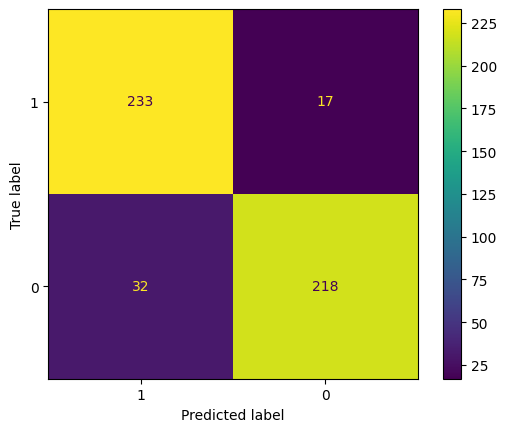

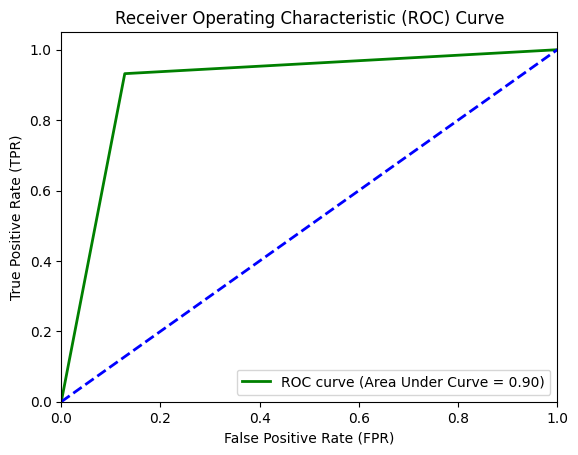

In [40]:
plot_accuracy_curve(model1)
performance(test_df['related_manual'],y_pred1)

In [41]:
siamese_2 = initialise_siamese_network(300,word2vec_embedding_matrix,'adam',0.1)
siamese_2.summary()

2023-08-04 01:43:33.297356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 01:43:33.298712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 01:43:33.300147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 50)           3070500     ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 subtract_1 (Subtract)          (None, 50)           0           ['sequential_1[0][0]',     

2023-08-04 01:43:33.646705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 01:43:33.647824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 01:43:33.648952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [42]:
%%time
model2 = siamese_2.fit([tweet_left, tweet_right], dataset_pairwise.is_similar, epochs=5)

Epoch 1/5


2023-08-04 01:43:34.045111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 01:43:34.047057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 01:43:34.048542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

154/154 [==============================] - 24s 133ms/step - loss: 0.5407 - accuracy: 0.7127
Epoch 2/5
154/154 [==============================] - 20s 130ms/step - loss: 0.1237 - accuracy: 0.9665
Epoch 3/5
154/154 [==============================] - 20s 128ms/step - loss: 0.0891 - accuracy: 0.9773
Epoch 4/5
154/154 [==============================] - 20s 130ms/step - loss: 0.0728 - accuracy: 0.9861
Epoch 5/5
154/154 [==============================] - 19s 126ms/step - loss: 0.0651 - accuracy: 0.9900
CPU times: user 1min 21s, sys: 18.9 s, total: 1min 40s
Wall time: 1min 43s


In [43]:
%%time
y_pred2 = [predict(tweet, fewshot_df, compare_tweet_sequences_padded,siamese_2) for tweet in test_df['tweet_original']]

2023-08-04 01:45:16.967043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 01:45:16.968602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 01:45:16.969935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 45ms/step
CPU times: user 1min 32s, sys: 16.5 s, total: 1min 48s
Wall time: 1min 55s


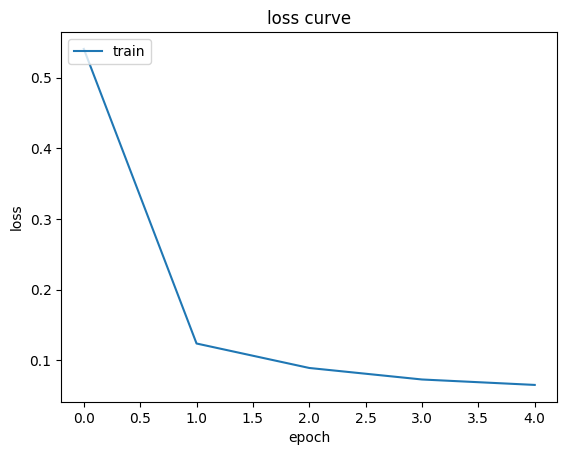

Accuracy: 76.8%
[246   4 112 138]
TP: 246
FP: 112
TN: 138
FN: 4
Sensitivity: 98.4%
Specificity: 55.2%
Precision: 68.715%
Recall: 98.4%
f1: 80.921%


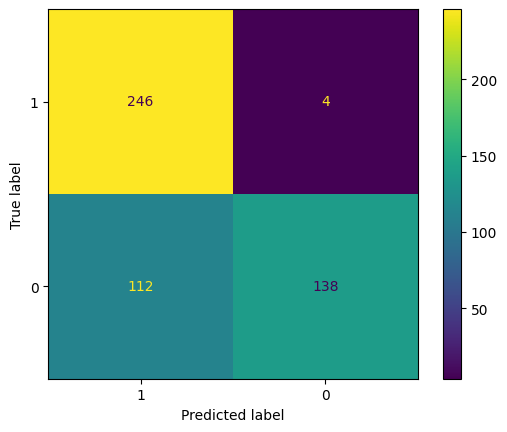

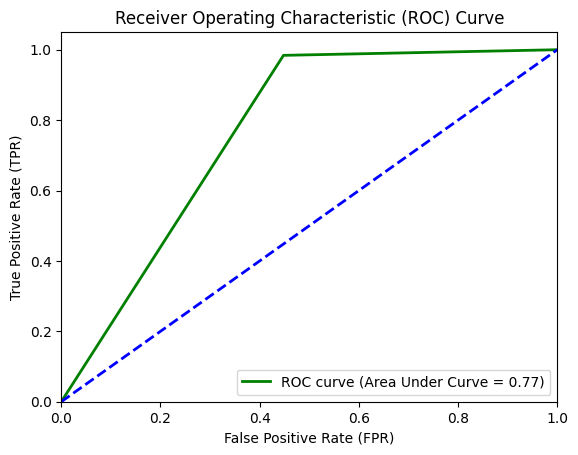

In [44]:
plot_accuracy_curve(model2)
performance(test_df['related_manual'],y_pred2)

In [45]:
siamese_3 = initialise_siamese_network(300,word2vec_embedding_matrix,'adam',0.001)
siamese_3.summary()

2023-08-04 01:53:53.508425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 01:53:53.509579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 01:53:53.510631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 sequential_2 (Sequential)      (None, 50)           3070500     ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 subtract_2 (Subtract)          (None, 50)           0           ['sequential_2[0][0]',     

2023-08-04 01:53:53.876525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 01:53:53.877616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 01:53:53.878857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [46]:
%%time
model3 = siamese_3.fit([tweet_left, tweet_right], dataset_pairwise.is_similar, epochs=5)

Epoch 1/5


2023-08-04 01:53:54.205456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 01:53:54.206563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 01:53:54.207819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

154/154 [==============================] - 23s 130ms/step - loss: 0.7931 - accuracy: 0.5376
Epoch 2/5
154/154 [==============================] - 20s 128ms/step - loss: 0.4764 - accuracy: 0.7835
Epoch 3/5
154/154 [==============================] - 20s 129ms/step - loss: 0.3065 - accuracy: 0.9220
Epoch 4/5
154/154 [==============================] - 20s 129ms/step - loss: 0.2397 - accuracy: 0.9508
Epoch 5/5
154/154 [==============================] - 20s 128ms/step - loss: 0.1685 - accuracy: 0.9765
CPU times: user 1min 19s, sys: 18.9 s, total: 1min 38s
Wall time: 1min 42s


In [47]:
%%time
y_pred3 = [predict(tweet, fewshot_df, compare_tweet_sequences_padded,siamese_3) for tweet in test_df['tweet_original']]

2023-08-04 01:55:36.500805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 01:55:36.501794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 01:55:36.502920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/4 [======>.......................] - ETA: 2s

2023-08-04 01:55:36.816528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-04 01:55:36.821398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 39ms/step
CPU times: user 1min 31s, sys: 16.3 s, total: 1min 47s
Wall time: 1min 56s


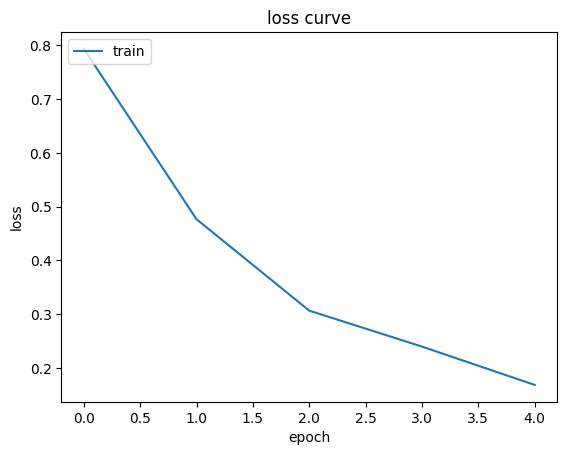

Accuracy: 88.8%
[223  27  29 221]
TP: 223
FP: 29
TN: 221
FN: 27
Sensitivity: 89.2%
Specificity: 88.4%
Precision: 88.492%
Recall: 89.2%
f1: 88.845%


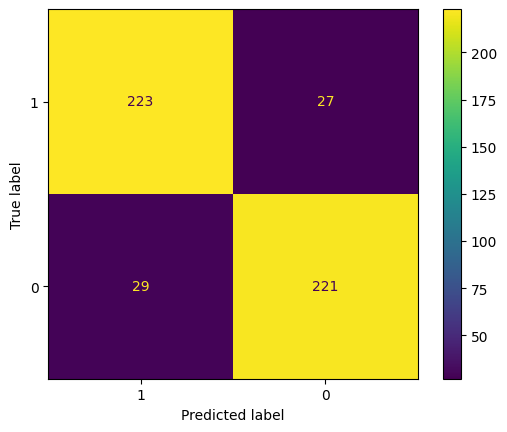

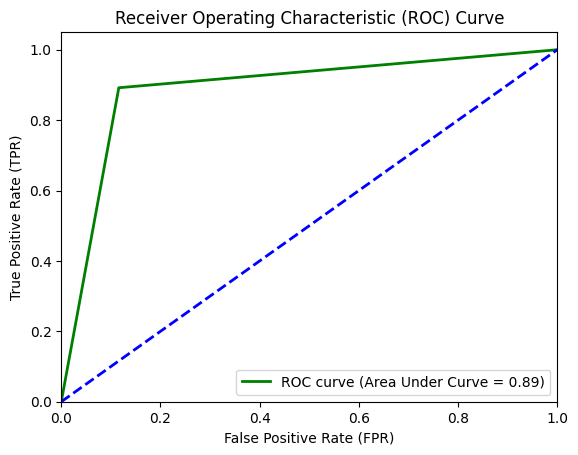

In [48]:
plot_accuracy_curve(model3)
performance(test_df['related_manual'],y_pred3)

In [49]:
siamese_4 = initialise_siamese_network(300,word2vec_embedding_matrix,'adam',0.001)
siamese_4.summary()

2023-08-04 01:59:31.603832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 01:59:31.605116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 01:59:31.606212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 sequential_3 (Sequential)      (None, 50)           3070500     ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 subtract_3 (Subtract)          (None, 50)           0           ['sequential_3[0][0]',     

2023-08-04 01:59:32.016653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 01:59:32.017901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 01:59:32.018867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [50]:
%%time
model4 = siamese_4.fit([tweet_left, tweet_right], dataset_pairwise.is_similar, epochs=10)

Epoch 1/10


2023-08-04 01:59:32.342052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 01:59:32.343140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 01:59:32.344293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

154/154 [==============================] - 25s 137ms/step - loss: 0.7957 - accuracy: 0.5327
Epoch 2/10
154/154 [==============================] - 20s 132ms/step - loss: 0.5387 - accuracy: 0.7310
Epoch 3/10
154/154 [==============================] - 20s 133ms/step - loss: 0.3341 - accuracy: 0.9100
Epoch 4/10
154/154 [==============================] - 20s 132ms/step - loss: 0.2411 - accuracy: 0.9598
Epoch 5/10
154/154 [==============================] - 21s 133ms/step - loss: 0.1850 - accuracy: 0.9767
Epoch 6/10
154/154 [==============================] - 21s 135ms/step - loss: 0.1511 - accuracy: 0.9810
Epoch 7/10
154/154 [==============================] - 21s 134ms/step - loss: 0.1222 - accuracy: 0.9871
Epoch 8/10
154/154 [==============================] - 21s 134ms/step - loss: 0.1001 - accuracy: 0.9933
Epoch 9/10
154/154 [==============================] - 20s 133ms/step - loss: 0.0740 - accuracy: 0.9988
Epoch 10/10
154/154 [==============================] - 21s 135ms/step - loss: 0.0605

In [51]:
%%time
y_pred4 = [predict(tweet, fewshot_df, compare_tweet_sequences_padded,siamese_4) for tweet in test_df['tweet_original']]

2023-08-04 02:03:01.892735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 02:03:01.894233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 02:03:01.895776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/4 [======>.......................] - ETA: 2s

2023-08-04 02:03:02.187479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-04 02:03:02.193773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 44ms/step
CPU times: user 1min 32s, sys: 16.4 s, total: 1min 48s
Wall time: 1min 51s


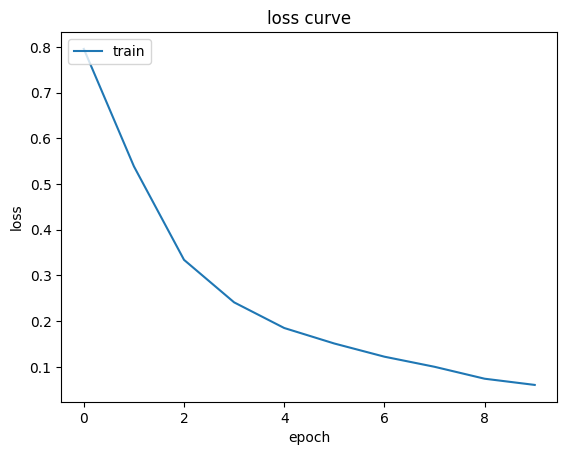

Accuracy: 89.6%
[233  17  35 215]
TP: 233
FP: 35
TN: 215
FN: 17
Sensitivity: 93.2%
Specificity: 86.0%
Precision: 86.94%
Recall: 93.2%
f1: 89.961%


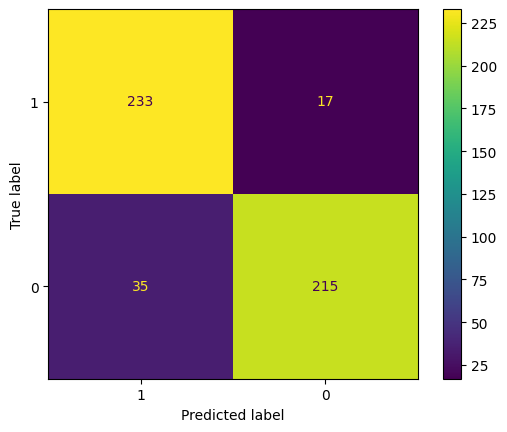

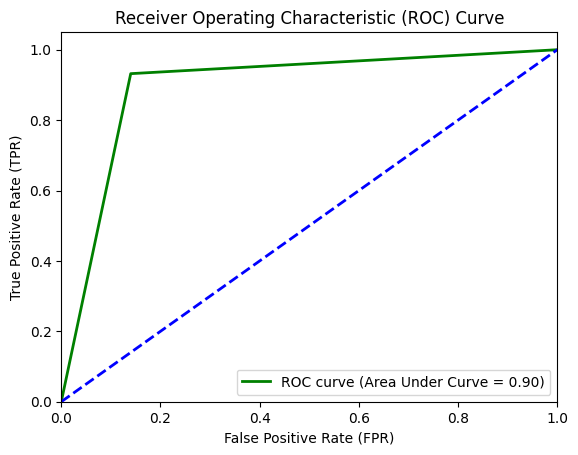

In [52]:
plot_accuracy_curve(model4)
performance(test_df['related_manual'],y_pred4)

In [94]:
siamese_5 = initialise_siamese_network(300,word2vec_embedding_matrix,'adam',0.01)
siamese_5.summary()

2023-08-06 17:16:51.922596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-06 17:16:51.923842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-06 17:16:51.924916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 sequential_15 (Sequential)     (None, 50)           3070500     ['input_33[0][0]',               
                                                                  'input_34[0][0]']               
                                                                                                  
 subtract_15 (Subtract)         (None, 50)           0           ['sequential_15[0][0]',   

2023-08-06 17:16:52.295699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-06 17:16:52.297417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-06 17:16:52.298748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [58]:
%%time
model5 = siamese_5.fit([tweet_left, tweet_right], dataset_pairwise.is_similar, epochs=20)

Epoch 1/20


2023-08-04 03:22:14.989055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 03:22:14.990118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 03:22:14.991817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

154/154 [==============================] - 25s 140ms/step - loss: 0.4804 - accuracy: 0.7818
Epoch 2/20
154/154 [==============================] - 21s 136ms/step - loss: 0.1817 - accuracy: 0.9555
Epoch 3/20
154/154 [==============================] - 21s 137ms/step - loss: 0.1348 - accuracy: 0.9733
Epoch 4/20
154/154 [==============================] - 21s 136ms/step - loss: 0.0486 - accuracy: 0.9900
Epoch 5/20
154/154 [==============================] - 21s 138ms/step - loss: 0.0266 - accuracy: 0.9971
Epoch 6/20
154/154 [==============================] - 21s 137ms/step - loss: 0.0201 - accuracy: 0.9998
Epoch 7/20
154/154 [==============================] - 21s 137ms/step - loss: 0.3022 - accuracy: 0.8680
Epoch 8/20
154/154 [==============================] - 21s 136ms/step - loss: 0.1966 - accuracy: 0.9371
Epoch 9/20
154/154 [==============================] - 20s 127ms/step - loss: 0.1442 - accuracy: 0.9631
Epoch 10/20
154/154 [==============================] - 21s 135ms/step - loss: 0.0988

In [59]:
%%time
y_pred5 = [predict(tweet, fewshot_df, compare_tweet_sequences_padded,siamese_5) for tweet in test_df['tweet_original']]

2023-08-04 03:29:18.019525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 03:29:18.020566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 03:29:18.021632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 45ms/step
CPU times: user 1min 31s, sys: 17.2 s, total: 1min 48s
Wall time: 1min 57s


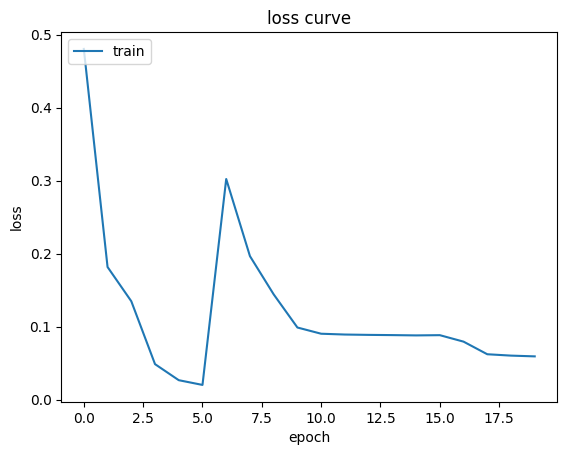

Accuracy: 93.6%
[247   3  29 221]
TP: 247
FP: 29
TN: 221
FN: 3
Sensitivity: 98.8%
Specificity: 88.4%
Precision: 89.493%
Recall: 98.8%
f1: 93.916%


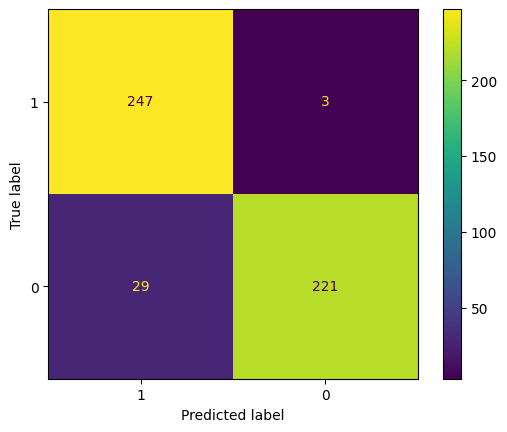

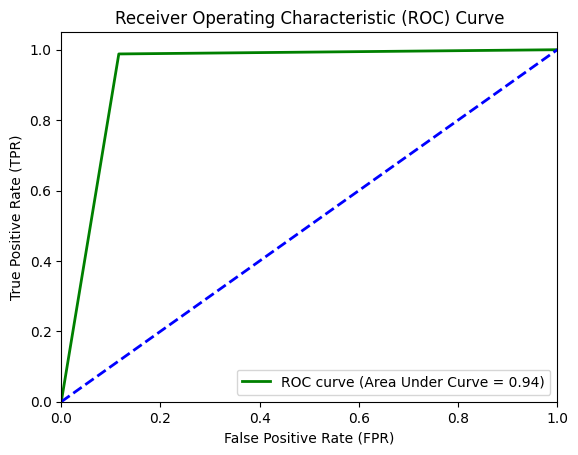

In [60]:
plot_accuracy_curve(model5)
performance(test_df['related_manual'],y_pred5)

In [95]:
siamese_6 = initialise_siamese_network(300,word2vec_embedding_matrix,'adam',0.01)
siamese_6.summary()

2023-08-06 17:18:00.529841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-06 17:18:00.531443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-06 17:18:00.533687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_36 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 sequential_16 (Sequential)     (None, 50)           3070500     ['input_35[0][0]',               
                                                                  'input_36[0][0]']               
                                                                                                  
 subtract_16 (Subtract)         (None, 50)           0           ['sequential_16[0][0]',   

In [96]:
%%time
model6 = siamese_6.fit([tweet_left, tweet_right], dataset_pairwise.is_similar, epochs=20)

Epoch 1/20


2023-08-06 17:18:01.328437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-06 17:18:01.329625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-06 17:18:01.330881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

154/154 [==============================] - 25s 136ms/step - loss: 0.4557 - accuracy: 0.8108
Epoch 2/20
154/154 [==============================] - 23s 147ms/step - loss: 0.2903 - accuracy: 0.8982
Epoch 3/20
154/154 [==============================] - 22s 143ms/step - loss: 0.1179 - accuracy: 0.9684
Epoch 4/20
154/154 [==============================] - 22s 143ms/step - loss: 0.0698 - accuracy: 0.9953
Epoch 5/20
154/154 [==============================] - 22s 142ms/step - loss: 0.0486 - accuracy: 0.9996
Epoch 6/20
154/154 [==============================] - 22s 142ms/step - loss: 0.0419 - accuracy: 1.0000
Epoch 7/20
154/154 [==============================] - 22s 143ms/step - loss: 0.0375 - accuracy: 0.9998
Epoch 8/20
154/154 [==============================] - 22s 142ms/step - loss: 0.0321 - accuracy: 1.0000
Epoch 9/20
154/154 [==============================] - 22s 142ms/step - loss: 0.0299 - accuracy: 1.0000
Epoch 10/20
154/154 [==============================] - 22s 142ms/step - loss: 0.0257

In [97]:
%%time
y_pred6 = [predict(tweet, fewshot_df, compare_tweet_sequences_padded,siamese_6) for tweet in test_df['tweet_original']]

2023-08-06 17:25:24.441527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-06 17:25:24.442457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-06 17:25:24.443419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 53ms/step
CPU times: user 1min 38s, sys: 19.9 s, total: 1min 58s
Wall time: 2min 10s


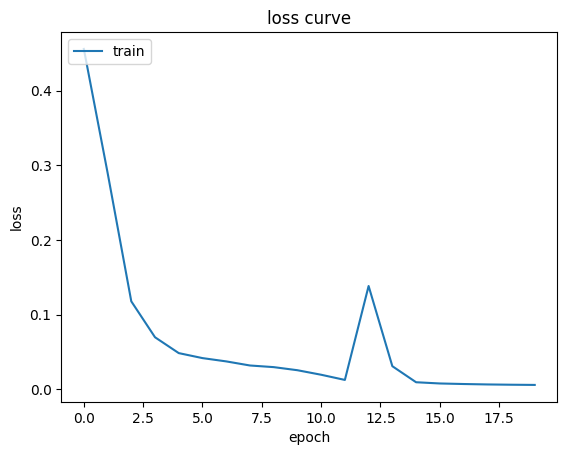

Accuracy: 88.2%
[232  18  41 209]
TP: 232
FP: 41
TN: 209
FN: 18
Sensitivity: 92.8%
Specificity: 83.6%
Precision: 84.982%
Recall: 92.8%
f1: 88.719%


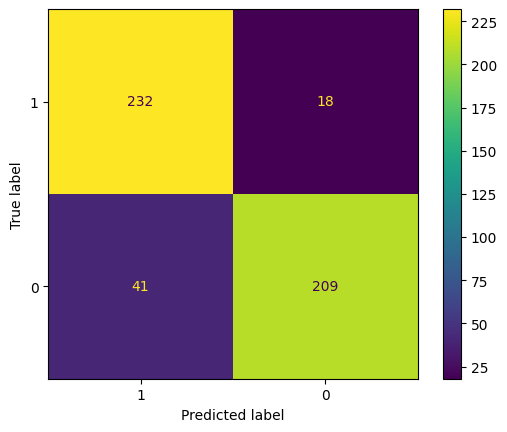

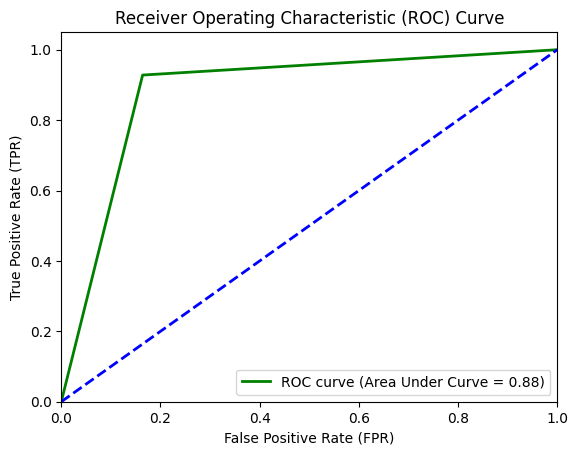

In [99]:
plot_accuracy_curve(model6)
performance(test_df['related_manual'],y_pred6)

In [88]:
siamese_7 = initialise_siamese_network(300,word2vec_embedding_matrix,'adam',0.01)
siamese_7.summary()

2023-08-06 17:04:28.734326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-06 17:04:28.736735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-06 17:04:28.738715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 sequential_14 (Sequential)     (None, 50)           3070500     ['input_31[0][0]',               
                                                                  'input_32[0][0]']               
                                                                                                  
 subtract_14 (Subtract)         (None, 50)           0           ['sequential_14[0][0]',   

2023-08-06 17:04:29.266417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-06 17:04:29.267868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-06 17:04:29.270056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [89]:
%%time
model7 = siamese_7.fit([tweet_left, tweet_right], dataset_pairwise.is_similar, epochs=20)

Epoch 1/20


2023-08-06 17:04:29.716924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-06 17:04:29.720886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-06 17:04:29.722254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

154/154 [==============================] - 28s 145ms/step - loss: 0.4743 - accuracy: 0.7806
Epoch 2/20
154/154 [==============================] - 21s 137ms/step - loss: 0.3438 - accuracy: 0.8665
Epoch 3/20
154/154 [==============================] - 21s 138ms/step - loss: 0.0967 - accuracy: 0.9869
Epoch 4/20
154/154 [==============================] - 21s 138ms/step - loss: 0.0684 - accuracy: 0.9873
Epoch 5/20
154/154 [==============================] - 21s 137ms/step - loss: 0.0558 - accuracy: 0.9878
Epoch 6/20
154/154 [==============================] - 21s 137ms/step - loss: 0.0370 - accuracy: 0.9918
Epoch 7/20
154/154 [==============================] - 20s 128ms/step - loss: 0.0235 - accuracy: 0.9973
Epoch 8/20
154/154 [==============================] - 21s 137ms/step - loss: 0.0182 - accuracy: 0.9994
Epoch 9/20
154/154 [==============================] - 21s 138ms/step - loss: 0.0147 - accuracy: 0.9998
Epoch 10/20
154/154 [==============================] - 21s 137ms/step - loss: 0.0121

In [90]:
%%time
y_pred7 = [predict(tweet, fewshot_df, compare_tweet_sequences_padded,siamese_7) for tweet in test_df['tweet_original']]

2023-08-06 17:11:47.034119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-06 17:11:47.035097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-06 17:11:47.036310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 45ms/step
CPU times: user 1min 39s, sys: 19 s, total: 1min 58s
Wall time: 2min 1s


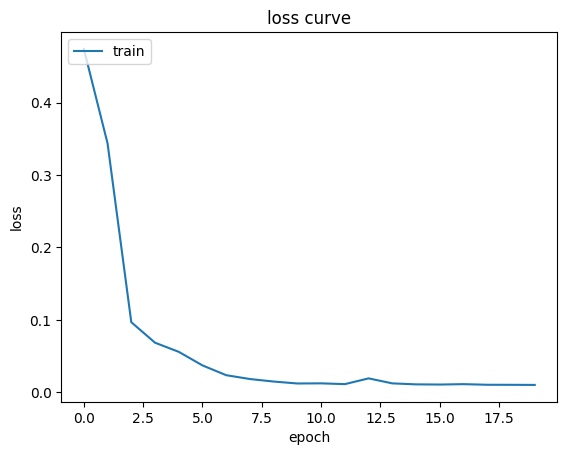

Accuracy: 91.4%
[232  18  25 225]
TP: 232
FP: 25
TN: 225
FN: 18
Sensitivity: 92.8%
Specificity: 90.0%
Precision: 90.272%
Recall: 92.8%
f1: 91.519%


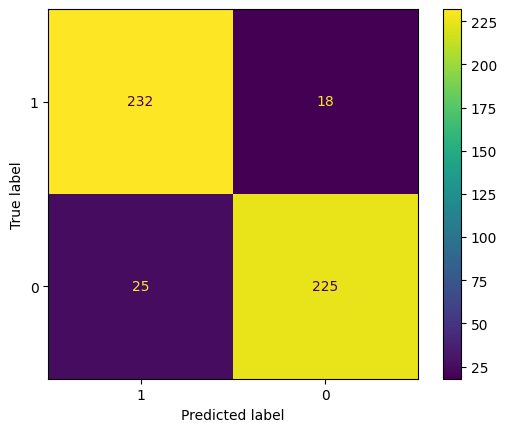

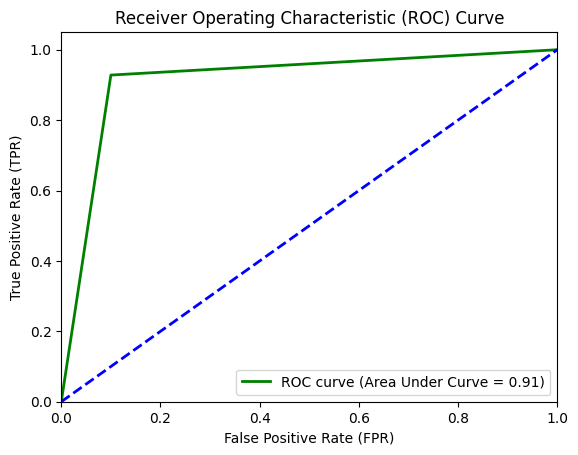

In [91]:
plot_accuracy_curve(model7)
performance(test_df['related_manual'],y_pred7)

In [66]:
siamese_8 = initialise_siamese_network(300,word2vec_embedding_matrix,'sgd',0.01)
siamese_8.summary()

2023-08-04 09:47:12.954093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 09:47:12.955351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 09:47:12.956634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 sequential_7 (Sequential)      (None, 50)           3070500     ['input_17[0][0]',               
                                                                  'input_18[0][0]']               
                                                                                                  
 subtract_7 (Subtract)          (None, 50)           0           ['sequential_7[0][0]',     

In [67]:
%%time
model8 = siamese_8.fit([tweet_left, tweet_right], dataset_pairwise.is_similar, epochs=20)

Epoch 1/20


2023-08-04 09:47:13.748117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 09:47:13.749286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 09:47:13.750458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

154/154 [==============================] - 24s 135ms/step - loss: 1.3981 - accuracy: 0.5022
Epoch 2/20
154/154 [==============================] - 21s 136ms/step - loss: 0.9920 - accuracy: 0.5173
Epoch 3/20
154/154 [==============================] - 20s 132ms/step - loss: 0.8731 - accuracy: 0.5149
Epoch 4/20
154/154 [==============================] - 20s 132ms/step - loss: 0.8221 - accuracy: 0.5151
Epoch 5/20
154/154 [==============================] - 20s 132ms/step - loss: 0.7952 - accuracy: 0.5143
Epoch 6/20
154/154 [==============================] - 20s 132ms/step - loss: 0.7762 - accuracy: 0.5202
Epoch 7/20
154/154 [==============================] - 21s 134ms/step - loss: 0.7605 - accuracy: 0.5200
Epoch 8/20
154/154 [==============================] - 21s 136ms/step - loss: 0.7498 - accuracy: 0.5218
Epoch 9/20
154/154 [==============================] - 21s 133ms/step - loss: 0.7370 - accuracy: 0.5263
Epoch 10/20
154/154 [==============================] - 21s 136ms/step - loss: 0.7256

In [68]:
%%time
y_pred8 = [predict(tweet, fewshot_df, compare_tweet_sequences_padded,siamese_8) for tweet in test_df['tweet_original']]

2023-08-04 09:54:08.391080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 09:54:08.392046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 09:54:08.393374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 50ms/step
CPU times: user 1min 33s, sys: 18.7 s, total: 1min 52s
Wall time: 2min 6s


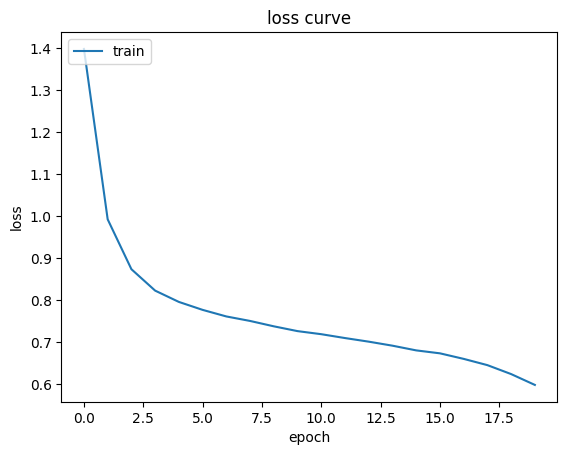

Accuracy: 80.4%
[188  62  36 214]
TP: 188
FP: 36
TN: 214
FN: 62
Sensitivity: 75.2%
Specificity: 85.6%
Precision: 83.929%
Recall: 75.2%
f1: 79.325%


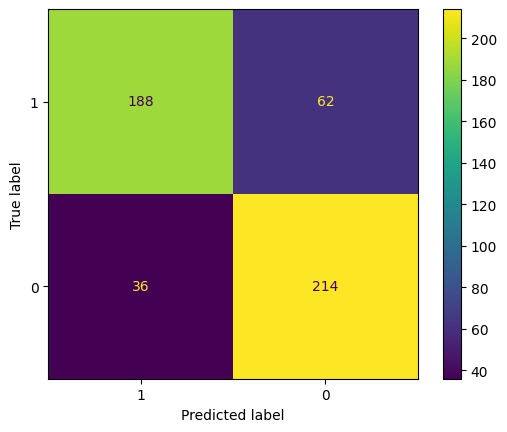

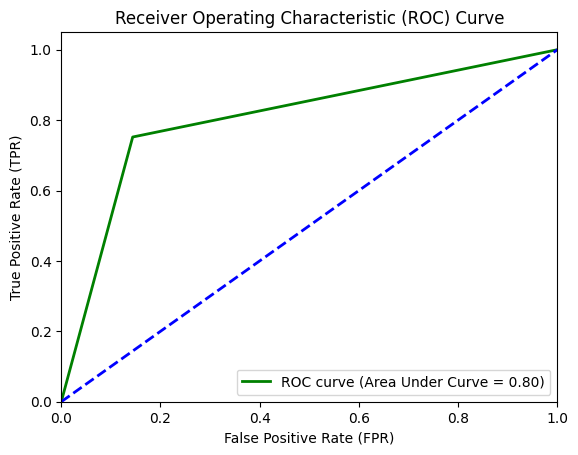

In [69]:
plot_accuracy_curve(model8)
performance(test_df['related_manual'],y_pred8)

In [61]:
siamese_9 = initialise_siamese_network(300,word2vec_embedding_matrix,'adam',0.01)
siamese_9.summary()

2023-08-04 09:28:40.253259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 09:28:40.254194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 09:28:40.255515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 300)]        0           []                               
                                                                                                  
 sequential_6 (Sequential)      (None, 50)           3070500     ['input_15[0][0]',               
                                                                  'input_16[0][0]']               
                                                                                                  
 subtract_6 (Subtract)          (None, 50)           0           ['sequential_6[0][0]',     

2023-08-04 09:28:40.612779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 09:28:40.613729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 09:28:40.615881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [62]:
%%time
model6 = siamese_9.fit([tweet_left, tweet_right], dataset_pairwise.is_similar, epochs=30)

Epoch 1/30


2023-08-04 09:28:48.426267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 09:28:48.427597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 09:28:48.428734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

154/154 [==============================] - 24s 136ms/step - loss: 0.4310 - accuracy: 0.8218
Epoch 2/30
154/154 [==============================] - 20s 130ms/step - loss: 0.3052 - accuracy: 0.8843
Epoch 3/30
154/154 [==============================] - 21s 136ms/step - loss: 0.1749 - accuracy: 0.9633
Epoch 4/30
154/154 [==============================] - 21s 134ms/step - loss: 0.1266 - accuracy: 0.9786
Epoch 5/30
154/154 [==============================] - 21s 133ms/step - loss: 0.1106 - accuracy: 0.9790
Epoch 6/30
154/154 [==============================] - 21s 134ms/step - loss: 0.1214 - accuracy: 0.9735
Epoch 7/30
154/154 [==============================] - 21s 137ms/step - loss: 0.0977 - accuracy: 0.9829
Epoch 8/30
154/154 [==============================] - 21s 133ms/step - loss: 0.3280 - accuracy: 0.8843
Epoch 9/30
154/154 [==============================] - 21s 134ms/step - loss: 0.1714 - accuracy: 0.9592
Epoch 10/30
154/154 [==============================] - 20s 133ms/step - loss: 0.1468

In [63]:
%%time
y_pred9 = [predict(tweet, fewshot_df, compare_tweet_sequences_padded,siamese_9) for tweet in test_df['tweet_original']]

2023-08-04 09:40:06.988771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-04 09:40:06.990379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-04 09:40:06.992260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

4/4 [==============================] - 0s 41ms/step
CPU times: user 1min 43s, sys: 19.2 s, total: 2min 2s
Wall time: 2min 9s


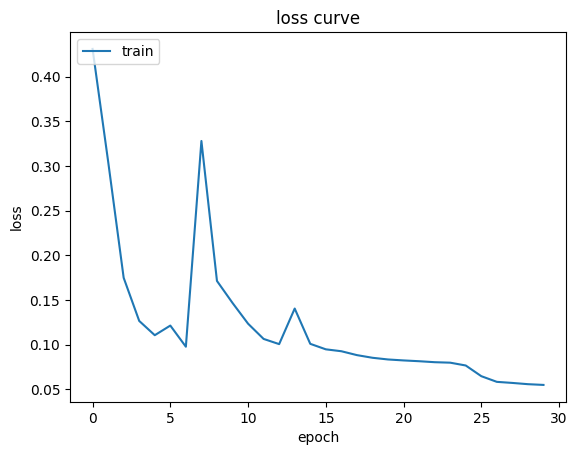

Accuracy: 64.6%
[100 150  27 223]
TP: 100
FP: 27
TN: 223
FN: 150
Sensitivity: 40.0%
Specificity: 89.2%
Precision: 78.74%
Recall: 40.0%
f1: 53.05%


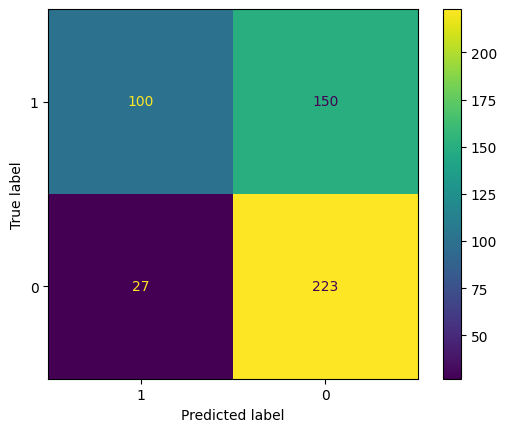

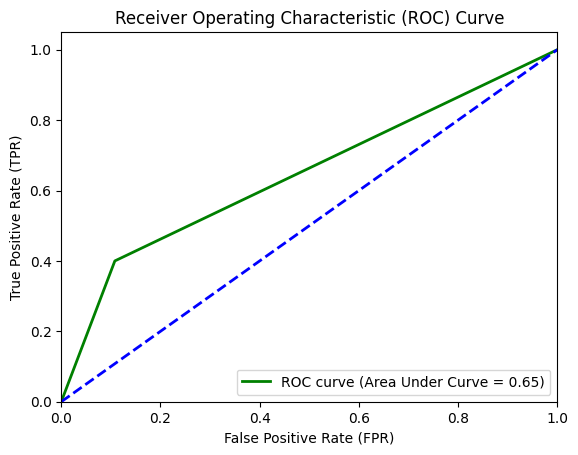

In [65]:
plot_accuracy_curve(model9)
performance(test_df['related_manual'],y_pred9)

<h2>Results<h2>
<h5>The best model is the one with following hyperparamteters
    <ol><li>Epochs - 20</li>
        <li>Learning rate - 0.01</li>
        <li>Optimizer - Adam with gradient clipping</li></ol>
    <h5>

| Model              | Accuracy | TP  | FP | TN  | FN | Sensitivity | Specificity | Precision | Recall | f1-score |
|--------------------|----------|-----|----|-----|----|-------------|-------------|-----------|--------|----------|
| Few shot (Siamese) | 91.4%    | 232 | 25 | 225 | 18 | 92.8%       | 90.0%       | 90.272%   | 92.8%  | 91.519%  |